Dataset: Time Series daily Website Visitors

Quelle: https://www.kaggle.com/datasets/bobnau/daily-website-visitors

Inhalt: 5 Jahre tägliche Zeitreihendaten für verschiedene Messgrößen des Traffics auf einer Website für statistische Prognosen (statforecasting.com)

Variablen:
- tägliche Anzahl der Seitenaufrufe
- der einmaligen Besucher
- der Erstbesucher
- der wiederkehrenden Besucher

Zeitraum: 14.09.2014 - 19.08.2020

Ein Besuch ist definiert als ein Strom von Zugriffen auf eine oder mehrere Seiten der Website an einem bestimmten Tag durch ein und denselben Nutzer, der über die IP-Adresse identifiziert wird. 

Mehrere Personen mit einer gemeinsamen IP-Adresse (z. B. in einem Computerlabor) werden als ein einziger Nutzer betrachtet, so dass reale Nutzer bis zu einem gewissen Grad unterschätzt werden können. 

Ein Besuch wird als "einmalig" eingestuft, wenn es innerhalb der letzten 6 Stunden keinen Treffer von derselben IP-Adresse gegeben hat. 

Wiederkehrende Besucher werden durch Cookies identifiziert, wenn diese akzeptiert werden. 

Alle anderen werden als Erstbesucher eingestuft, so dass die Zahl der einmaligen Besucher per Definition die Summe der Zahlen der wiederkehrenden und der erstmaligen Besucher ist. 

Die Daten wurden über einen Verkehrsüberwachungsdienst namens StatCounter gesammelt.


Ziel: Vorhersage der **Page Loads**

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.tsa.seasonal as statseason
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA  # Instead of statsmodels.tsa.arima_model.ARIMA
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from pmdarima.arima import auto_arima
from scipy.stats import chi2

***1. Loading and Preprocessing***

In [2]:
# Load the data
data_path = "./daily-website-visitors.csv"
data = pd.read_csv(data_path)

data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


In [4]:
# Function to remove commas
def remove_commas(x):
    return float(x.replace(',', ''))

In [5]:
# Apply the preprocessing functions
data['Date'] = pd.to_datetime(data['Date'])
data['Page.Loads'] = data['Page.Loads'].apply(lambda x : remove_commas(x))
data['Unique.Visits'] = data['Unique.Visits'].apply(lambda x : remove_commas(x))
data['First.Time.Visits'] = data['First.Time.Visits'].apply(lambda x : remove_commas(x))
data['Returning.Visits'] = data['Returning.Visits'].apply(lambda x : remove_commas(x))

In [6]:
data = data.drop(['Row','Day'], axis = 1)

In [7]:
col = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']

data[col] = data[col].replace(',', '', regex = True).astype('int64')

In [8]:
data['Date'] = data['Date'].astype('datetime64[ns]')
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data.drop(columns = 'Date', inplace = True)

In [9]:
data["full_date"] = pd.to_datetime(data[['year', 'month', 'day']])

In [10]:
data.head()

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,year,month,day,full_date
0,1,2146,1582,1430,152,2014,9,14,2014-09-14
1,2,3621,2528,2297,231,2014,9,15,2014-09-15
2,3,3698,2630,2352,278,2014,9,16,2014-09-16
3,4,3667,2614,2327,287,2014,9,17,2014-09-17
4,5,3316,2366,2130,236,2014,9,18,2014-09-18


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Day.Of.Week        2167 non-null   int64         
 1   Page.Loads         2167 non-null   int64         
 2   Unique.Visits      2167 non-null   int64         
 3   First.Time.Visits  2167 non-null   int64         
 4   Returning.Visits   2167 non-null   int64         
 5   year               2167 non-null   int64         
 6   month              2167 non-null   int64         
 7   day                2167 non-null   int64         
 8   full_date          2167 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(8)
memory usage: 152.5 KB


***EDA***

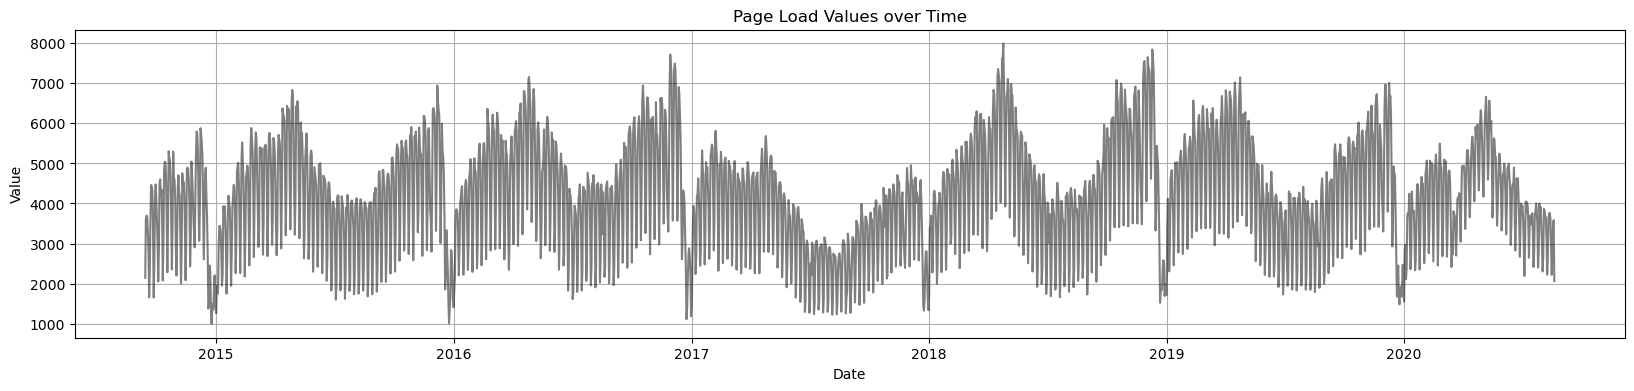

In [12]:
values = data['Page.Loads'].values
timestamps = data['full_date'].values

plt.figure(figsize=(20, 4))
plt.plot(timestamps, values, linestyle='-', color='black', alpha=0.5)

plt.title('Page Load Values over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.show()

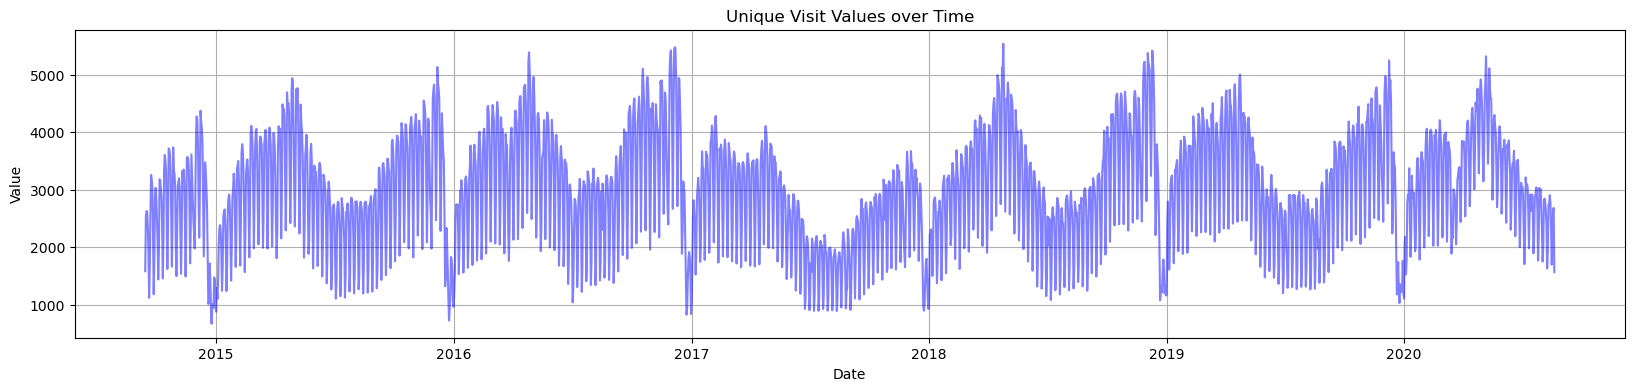

In [13]:
values = data['Unique.Visits'].values
timestamps = data['full_date'].values

plt.figure(figsize=(20, 4))
plt.plot(timestamps, values, linestyle='-', color='blue', alpha=0.5)

plt.title('Unique Visit Values over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.show()

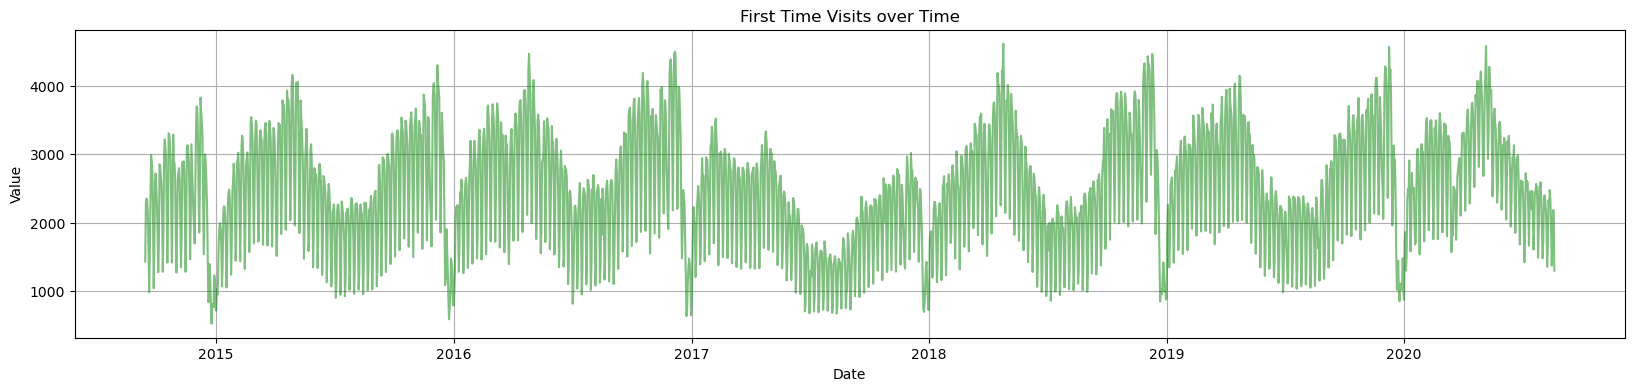

In [14]:
values = data['First.Time.Visits'].values
timestamps = data['full_date'].values

plt.figure(figsize=(20, 4))
plt.plot(timestamps, values, linestyle='-', color='green', alpha=0.5)

plt.title('First Time Visits over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.show()

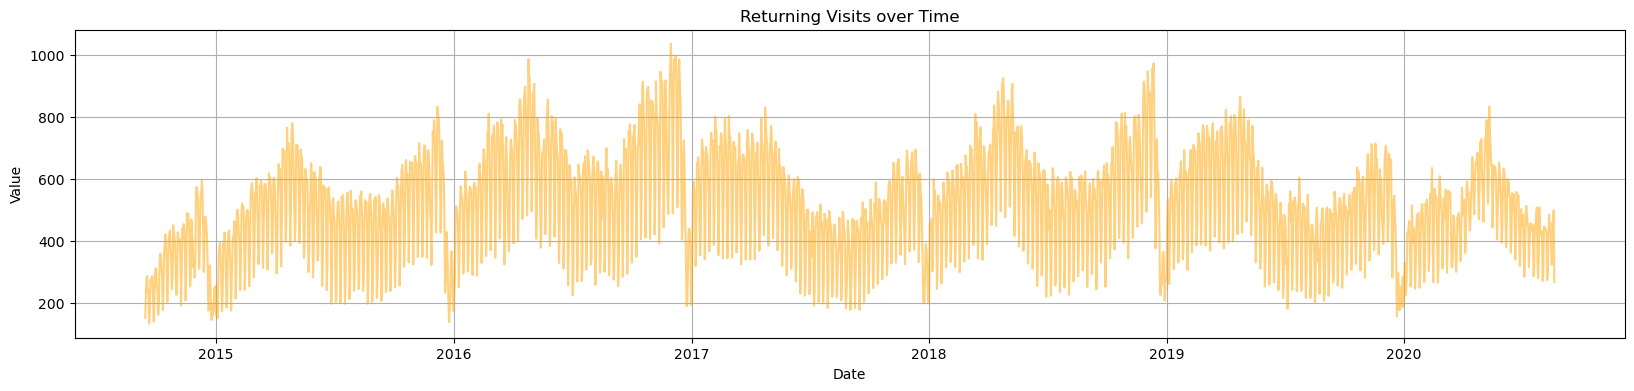

In [15]:
values = data['Returning.Visits'].values
timestamps = data['full_date'].values

plt.figure(figsize=(20, 4))
plt.plot(timestamps, values, linestyle='-', color='orange', alpha=0.5)

plt.title('Returning Visits over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.show()

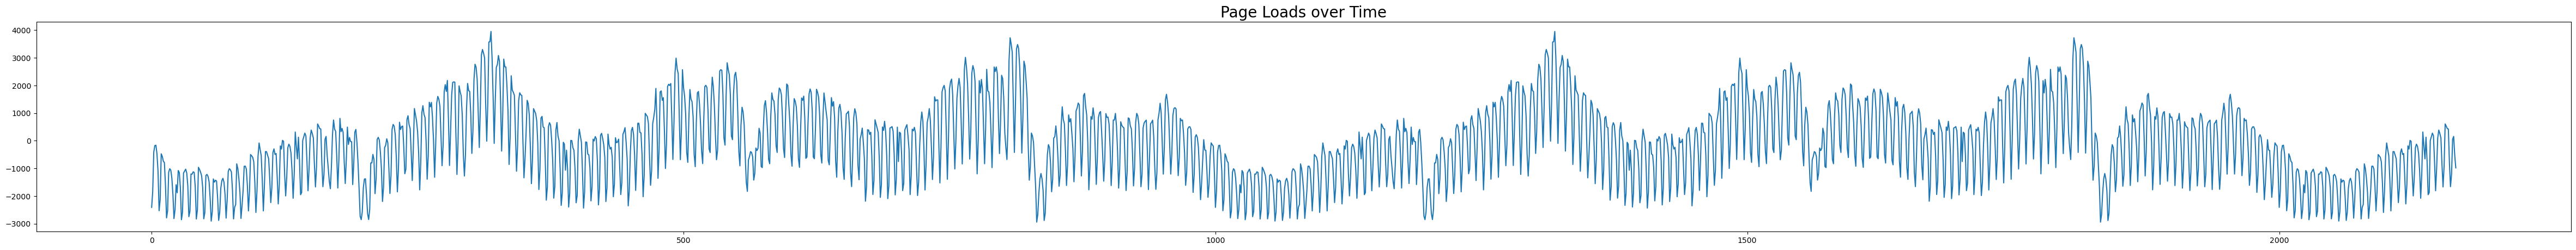

In [16]:
page_loads = data[['Page.Loads']] # can leave out date here because already sorted by date

plt.figure(figsize=(60,5))
plt.title('Page Loads over Time', fontsize=20)
season = statseason.seasonal_decompose(page_loads, model = "additive", period = 1000)
season.seasonal.plot()
plt.show()

<AxesSubplot:>

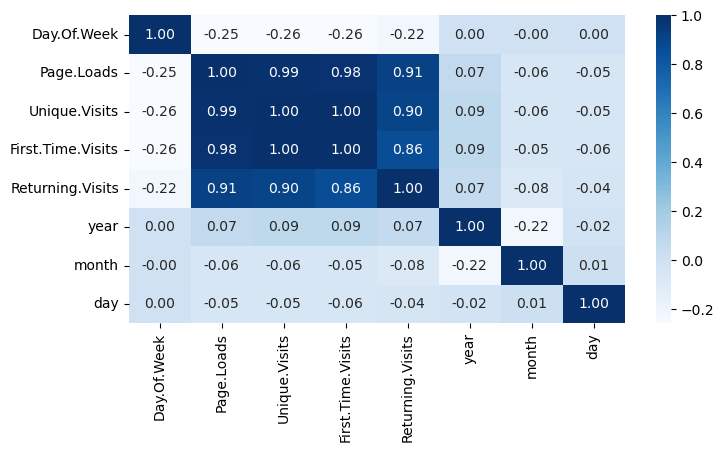

In [17]:
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="Blues", annot=True, fmt=".2f")

In [18]:
## Unique Visits, First Time Visits und Returning Visits raus, da Page Load die Summe dieser ist

data = data.drop(['Unique.Visits', 'First.Time.Visits', 'Returning.Visits'], axis = 1)

***Test auf schwache Stationarität***

*Eine Zeitreihe ist schwach stationär, wenn ihr Mittelwert und ihre Varianz über die Zeit konstant sind und die Kovarianz zwischen zwei Zeitpunkten nur von der Zeitdifferenz und nicht von den tatsächlichen Zeitpunkten abhängt.*

Varianz-Kovarianz-Matrix ist nicht direkt geeignet, da sie nur Infos über zeitgleiche Beziehungen zwischen Beobachtungen liefert

In [19]:
# für die Tests Page Loads und full day 

X = pd.DataFrame(page_loads)
y = pd.DataFrame(timestamps)

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Page.Loads  2167 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       2167 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.1 KB
None


In [20]:
dataframe = pd.concat([y, X], axis=1)
dataframe.columns = ['full_date', 'Page.Loads']

In [21]:
dataframe.head()

,full_date,Page.Loads
0,2014-09-14,2146
1,2014-09-15,3621
2,2014-09-16,3698
3,2014-09-17,3667
4,2014-09-18,3316


Warum?

- ACF und PACF helfen bei der Beurteilung, ob eine Zeitreihe stationär ist, d.h. ob ihre statistischen Eigenschaften (Mittelwert, Varianz, Autokorrelation) über die Zeit konstant bleiben.
- Stationäre Zeitreihen sind Voraussetzung

Die ACF zeigt die Korrelation der Zeitreihe mit sich selbst in verschiedenen Abständen (Lags).
- Hohe Werte bei Lags ungleich Null deuten auf Muster oder Trends in der Abhängigkeit der Werte hin.


Die PACF zeigt die zusätzliche Korrelation, die nicht durch die Korrelation bei kleineren Lags erklärt werden kann.
- kann helfen, versteckte Muster oder Einflüsse in der Zeitreihe zu identifizieren.

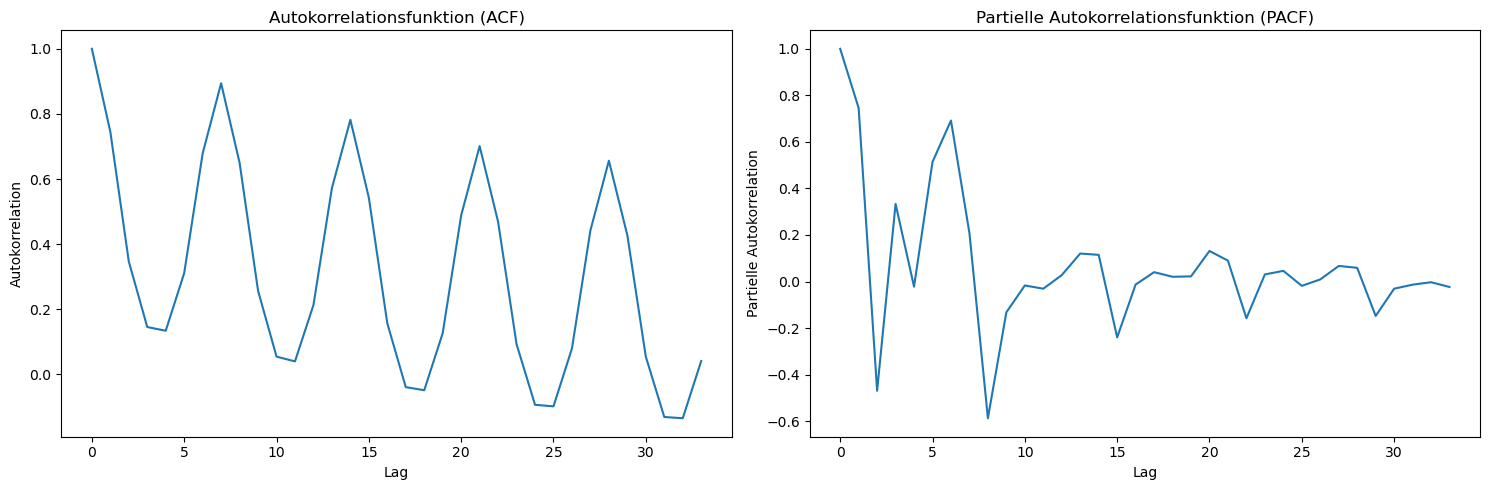

In [22]:
# Autokorrelationsfunktion und Partialautokorrelationsfunktion
acf_result = acf(X)
pacf_result = pacf(X)

plt.figure(figsize=(15, 5))

# Plotten der ACF
plt.subplot(1, 2, 1)
plt.plot(acf_result)
plt.title('Autokorrelationsfunktion (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autokorrelation')

# Plotten der PACF
plt.subplot(1, 2, 2)
plt.plot(pacf_result)
plt.title('Partielle Autokorrelationsfunktion (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partielle Autokorrelation')

plt.tight_layout()
plt.show()


In der ACF sehen wir, dass die Autokorrelation bei Lag 1 und Lag 2 signifikant positiv ist. Dies deutet darauf hin, dass die Werte der Zeitreihe stark mit den Werten der Zeitreihe in den beiden vorangegangenen Perioden korrelieren.

Die Autokorrelation fällt dann schnell ab und wird bei Lags größer als 5 nicht signifikant. Dies deutet darauf hin, dass die Werte der Zeitreihe nach Lag 5 nicht mehr stark mit den Werten in der Vergangenheit korrelieren.

In der PACF sehen wir, dass die partielle Autokorrelation nur bei Lag 1 signifikant positiv ist. Dies deutet darauf hin, dass die Werte der Zeitreihe direkt mit den Werten der Zeitreihe in der vorangegangenen Periode korrelieren, aber die Korrelation bei Lags größer als 1 nicht durch die Korrelation bei kleineren Lags erklärt werden kann.

Die ACF und PACF zeigen, dass die Zeitreihe eine signifikante Autokorrelation bei Lag 1 und Lag 2 aufweist. Dies deutet darauf hin, dass die Werte der Zeitreihe stark von den Werten in den beiden vorangegangenen Perioden abhängen.

Die PACF zeigt jedoch, dass die Korrelation bei Lags größer als 1 nicht durch die Korrelation bei kleineren Lags erklärt werden kann. Dies deutet darauf hin, dass die Zeitreihe keine starke saisonale Komponente hat.

.

Fehlende Informationen: Die Grafiken zeigen zwar die ACF und PACF, aber es fehlen wichtige Informationen wie:

Signifikanzniveaus: Waren die Autokorrelationen bei relevanten Lags statistisch signifikant?

Lag-Struktur: Wie sehen die ACF und PACF in höheren Lags aus?

Zeitreihenplot: Wie sieht die Original-Zeitreihe aus? Gibt es offensichtliche Trends oder Saisonalität?

Zusätzliche Tests: Neben ACF und PACF sind für die Beurteilung der Stationarität oft Unit-Root-Tests wie der Dickey-Fuller-Test (ADF) oder der Phillips-Peron-Test (PP) notwendig.

***Dickey Fuller Test***

In [23]:
# Dickey-Fuller-Test durchführen
result = adfuller(X)

# Ergebnisse interpretieren
print('Dickey-Fuller Test Statistik:', result[0])
print('p-Wert:', result[1])
print('Lag verwendet:', result[2])
print('Anzahl der Beobachtungen:', result[3])
print('Kritische Werte:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Interpretation des Ergebnisses
if result[1] <= 0.05:
    print("Signifikanzniveau 5%: Die Zeitreihe ist stationär.")
else:
    print("Signifikanzniveau 5%: Die Zeitreihe ist nicht stationär.")


Dickey-Fuller Test Statistik: -4.2838214361876705
p-Wert: 0.00047375782574649754
Lag verwendet: 26
Anzahl der Beobachtungen: 2140
Kritische Werte:
	1%: -3.4334094211542983
	5%: -2.8628915360971003
	10%: -2.5674894918770197
Signifikanzniveau 5%: Die Zeitreihe ist stationär.


Da der p-Wert (0.00047) kleiner als das übliche Signifikanzniveau von 0.05 ist und die Teststatistik (-4.28) kleiner als die kritischen Werte bei 1%, 5% und 10% ist, können wir mit großer Sicherheit sagen, dass die Zeitreihe stationär ist. 

Dies bedeutet, dass die statistischen Eigenschaften der Zeitreihe im betrachteten Zeitraum stabil bleiben und nicht von einem Trend oder einer Zufallsschwankung dominiert werden.

falls die Zeitreihe nicht stationär ist, ggf. umformatieren

***Autoregressive Prozesse AR(p)***

Schätzer für P:

Akaike-Informationskriterium (AIC):

AIC ist ein Maß für die relative Qualität statistischer Modelle für einen gegebenen Datensatz.

BIC hat eine stärkere Verlagerung in Richtung der Strenge der Modellierung im Vergleich zum AIC und eignet sich gut, wenn der Datenumfang groß ist oder das Modell übermäßig komplex sein könnte.

Wähle die AR-Ordnung (p), die den AIC-Wert minimiert (sowie den BIC Wert).

In [24]:
# Leere Listen für AIC und BIC
aic_values = []
bic_values = []

# Schleife über verschiedene p-Werte
for p in range(0, 20):
    model = ARIMA(X, order=(p, 0, 0))  # AR(p) Modell, I(d)=0, MA(q)=0
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    aic_values.append(aic)
    bic_values.append(bic)

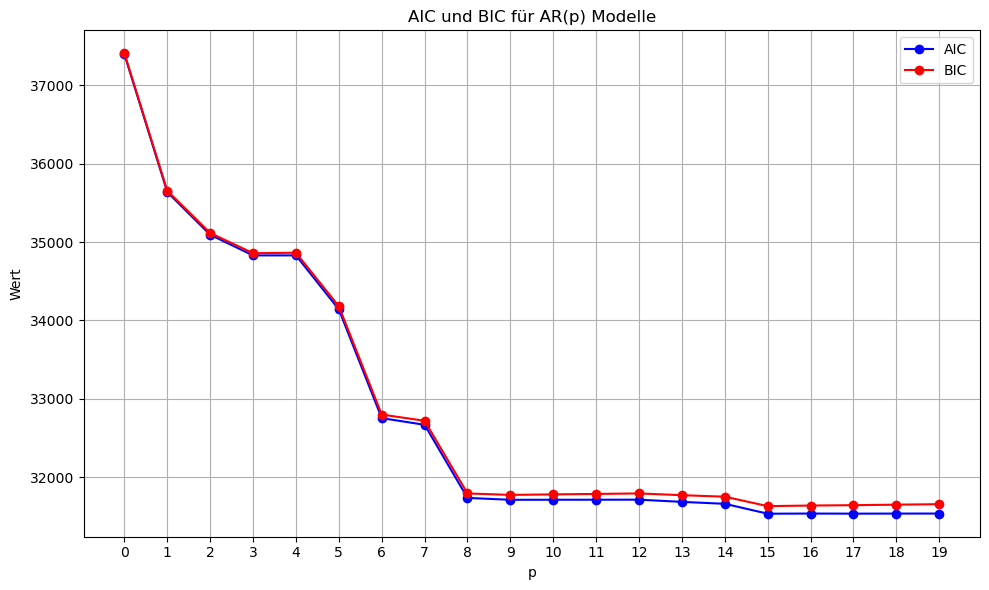

In [25]:
# Plot der AIC und BIC Werte
plt.figure(figsize=(10, 6))
plt.plot(range(0, 20), aic_values, marker='o', linestyle='-', color='b', label='AIC')
plt.plot(range(0, 20), bic_values, marker='o', linestyle='-', color='r', label='BIC')
plt.xticks(np.arange(0, 20, step=1))
plt.xlabel('p')
plt.ylabel('Wert')
plt.title('AIC und BIC für AR(p) Modelle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

hier Auswahl von p=15, da AIC und BIC konstant minimiert

In [26]:
# Modell mit ARMA(p, q) definieren
p = 15  # Ordnung des AR-Teils
q = 0   # Ordnung des MA-Teils, q auf 0 setzen für ein AR-Modell ohne MA-Komponente
q2 = 2 # Ordnung des MA-Teils, q2 auf 2 setzen für ein AR-Modell mit MA-Komponente

model = sm.tsa.ARIMA(X, order=(p, 0, 0))
model_fit = model.fit()

print(model_fit.summary())

# Bewerten Sie die Modellgüte anhand von AIC oder BIC
print()
aic = model_fit.aic
bic = model_fit.bic

print("AIC:", aic)
print("BIC:", bic)

                               SARIMAX Results                                
Dep. Variable:             Page.Loads   No. Observations:                 2167
Model:                ARIMA(15, 0, 0)   Log Likelihood              -15750.417
Date:                Sat, 22 Jun 2024   AIC                          31534.835
Time:                        14:46:45   BIC                          31631.414
Sample:                             0   HQIC                         31570.153
                               - 2167                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4116.9894    148.736     27.680      0.000    3825.472    4408.507
ar.L1          0.8471      0.018     48.360      0.000       0.813       0.881
ar.L2         -0.1384      0.027     -5.220      0.0

Heteroskedastizitätstest (H): Der P-Wert für den Heteroskedastizitätstest beträgt 0.01, was darauf hindeutet, dass es Anzeichen für Heteroskedastizität in den Residuen gibt. Dies bedeutet, dass die Varianz der Fehler nicht konstant ist und das Modell hier möglicherweise noch weiter verbessert werden könnte.

***Automatische Ermittlung des besten Arima Modells***

In [27]:
auto_model = auto_arima(X)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2167
Model:               SARIMAX(1, 0, 5)   Log Likelihood              -17024.791
Date:                Sat, 22 Jun 2024   AIC                          34063.581
Time:                        14:47:13   BIC                          34103.349
Sample:                             0   HQIC                         34078.124
                               - 2167                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   2.36e-07   4.24e+06      0.000       1.000       1.000
ma.L1          0.1769      0.018      9.828      0.000       0.142       0.212
ma.L2         -0.8446      0.016    -51.238      0.000      -0.877      -0.812
ma.L3         -0.6687      0.019    -34.306      0.000      -0.707      -0.630
ma.L4          0.3485      0.016     21.657      0.000       0.317       0.380
ma.L5          0.5718      0.018     31.413      0.000       0.536       0.608
sigma2      3.875e+05   1.27e-08   3.06e+13      0.000    3.88e+05    3.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                10.18
Prob(Q):                              0.78   Prob(JB):                         0.01
Heteroskedasticity (H):               0.91   Skew:                             0.15
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.06e+29. Standard errors may be unstable.
"""

Modell: SARIMA(1, 0, 5)

Allgemeine Anpassung:

Log-Likelihood: -17024,791 (niedrigere Werte deuten auf eine schlechtere Anpassung hin)
AIC/BIC/HQIC: 34063,581 / 34103,349 / 34078,124 (niedrigere Werte deuten auf ein besseres Gleichgewicht zwischen Modellkomplexität und Anpassung hin)

Koeffizientenschätzungen:

Alle Koeffizienten sind statistisch signifikant (p-Wert < 0,05), was auf eine gute Anpassung hinweist.
AR(1) ist sehr nahe an 1, was auf einen starken Einfluss des vorherigen Werts auf den aktuellen Wert hinweist.
Die MA-Terme (MA(1) bis MA(5)) erfassen den Einfluss vergangener Residuen auf den aktuellen Wert.
Diagnosetests:

Jarque-Bera-Test: Testet auf Normalität der Residuen. Der p-Wert (0,01) deutet darauf hin, dass die Residuen möglicherweise nicht normalverteilt sind.
Warnungen:


Gesamteinschätzung:
Das SARIMA(1, 0, 5)-Modell scheint den Trend und die Saisonalität in Ihren Daten aufgrund der signifikanten Koeffizienten und des Fehlens serieller Korrelation in den Residuen relativ gut zu erfassen.
Die nicht-normalen Residuen deuten jedoch darauf hin, dass das Modell möglicherweise nicht alle Fehlerterme perfekt erfasst.

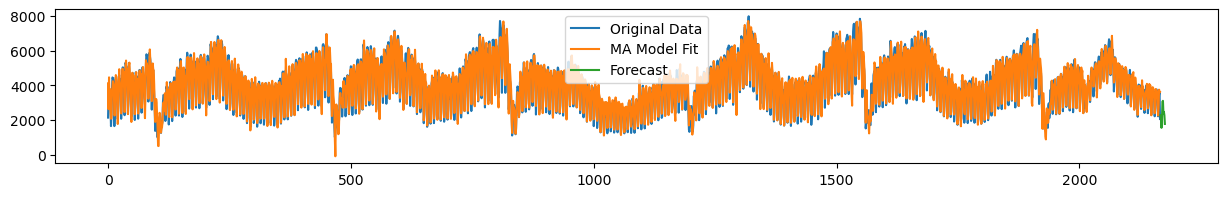

In [28]:
# Make predictions
forecast = model_fit.forecast(steps=10)

# Visualize results
plt.figure(figsize=(15, 2))
plt.plot(X, label="Original Data")
plt.plot(model_fit.fittedvalues, label="MA Model Fit")
plt.plot(forecast, label="Forecast")
plt.legend()
plt.show()

***Deterministsicher Trend***


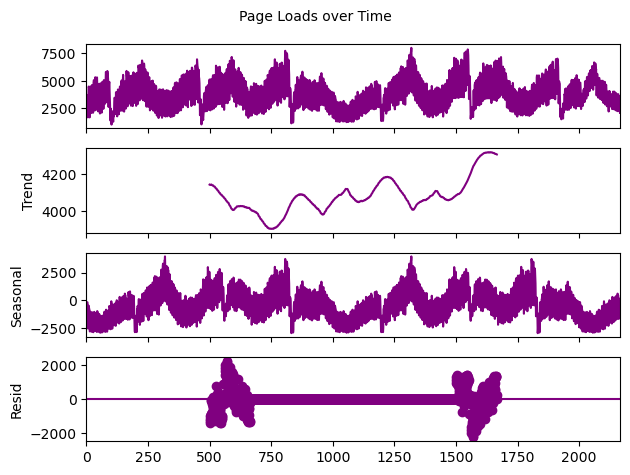

In [29]:
fig = season.plot()
fig.suptitle('Page Loads over Time', fontsize=10)
fig.tight_layout()

for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color('purple') 

plt.show()

Auch die Dickey-Fuller Test Statistik: -4.2838214361876705 -> H0 ablehnen, stationär

Wenn der Dickey-Fuller-Test die Nullhypothese ablehnt (was auf Stationarität hindeutet), deutet dies darauf hin, dass ein in der Zeitreihe beobachteter Trend wahrscheinlich deterministisch (systematisch und vorhersehbar) und nicht stochastisch (zufällig und unvorhersehbar) ist.

Mit anderen Worten: Der in den Daten beobachtete Trend kann mit größerer Sicherheit als ein echter, zugrunde liegender Trend interpretiert werden, der im Laufe der Zeit anhält, und nicht als Ergebnis zufälliger Schwankungen.

Text(0, 0.5, 'Partial Autocorrelation')

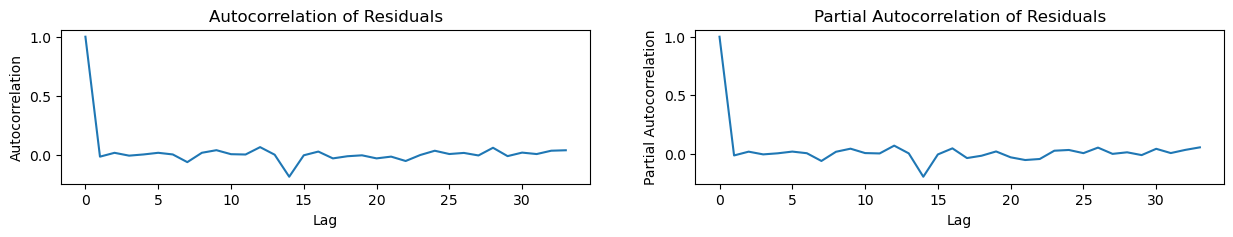

In [30]:
# Check for stationarity of residuals
acf_resid = acf(model_fit.resid)
pacf_resid = pacf(model_fit.resid)

plt.figure(figsize=(15, 2))
# Plot ACF of residuals
plt.subplot(1, 2, 1)
plt.plot(acf_resid)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# Plot PACF of residuals
plt.subplot(1, 2, 2)
plt.plot(pacf_resid)
plt.title('Partial Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')


Die ACF- und PACF-Plots legen nahe, dass in den Residuen des Zeitreihenmodells noch eine gewisse serielle Abhängigkeit besteht.


Dies könnte auf verschiedene Faktoren zurückzuführen sein, wie z. B. Saisonalität in den Daten, Ausreißer oder Trends, die vom Modell nicht ausreichend erfasst wurden.


Eine Überarbeitung des Modells in Betracht ziehen, um diese Abhängigkeiten zu berücksichtigen.

Die ACF und PACF zeigen eine signifikante Korrelation bei Lag 1, was auf eine serielle Abhängigkeit in den Residuen hindeutet.
Die PACF zeigt keinen signifikanten Spike bei höheren Lags, was darauf hindeutet, dass ein AR(1)-Modell ausreichend sein könnte, um die serielle Abhängigkeit zu erfassen.

***Random Walk***

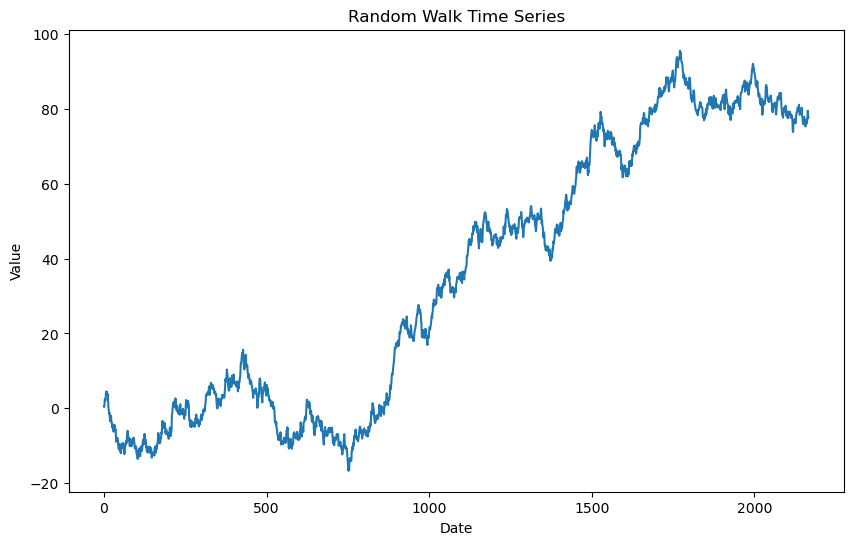

In [31]:
# Adding a column to the DataFrame (e.g., starting value)
dataframe['value'] = 0  # Initial value

# Random Walk Parameters
n_steps = len(dataframe)  # Number of steps based on the DataFrame length
step_mean = 0  # Mean of the step size
step_std = 1   # Standard deviation of the step size

# Generate random steps
np.random.seed(42)  # Set seed for reproducibility
steps = np.random.normal(loc=step_mean, scale=step_std, size=n_steps)

# Compute the random walk and assign to DataFrame
dataframe['random_walk'] = np.cumsum(steps)

# Plot the random walk
plt.figure(figsize=(10, 6))
plt.plot(dataframe.index, dataframe['random_walk'])
plt.title('Random Walk Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


Bei dem erzeugten Random Walk scheinen die Schritte zufällig zu sein und keinen erkennbaren Trend aufzuweisen.

Das bedeutet, dass der Wert zu jedem beliebigen Zeitpunkt unvorhersehbar ist und überall über oder unter dem Ausgangswert liegen kann.

***Test auf Superkonsistenz***

In [32]:
# Superkonsistenztest
# Annahme: y = random_walk + noise
dataframe['y'] = dataframe['random_walk'] + np.random.normal(size=n_steps)

# Regression
X = sm.add_constant(dataframe['random_walk'])
model = sm.OLS(dataframe['y'], X).fit()
beta_hat = model.params[1]
beta_true = 1.5  # Beispiel für den wahren Koeffizienten
T = n_steps

# Berechnung der Superkonsistenzbedingung
super_consistent = (beta_hat - beta_true) * T
print(f'Superkonsistenzbedingung: {super_consistent}')

Superkonsistenzbedingung: -1085.1345581910532


Der negative Wert zeigt, dass der geschätzte Koeffizient kleiner ist als der wahre Koeffizient, was auf eine Unterschätzung hindeutet.

--> Das bedeutet, dass das Modell den Einfluss des untersuchten Faktors auf die abhängige Variable geringer einschätzt, als es in Wirklichkeit der Fall ist.

***Test auf Cointegration***

In [33]:
# Test auf Kointegration
score, p_value, _ = coint(dataframe['y'], dataframe['random_walk'])

print(f'Teststatistik: {score}')
print(f'p-Wert: {p_value}')

Teststatistik: -47.89267878317703
p-Wert: 0.0


Der extrem niedrige p-Wert deutet darauf hin, dass die Zeitreihen y und random_walk kointegriert sind, also eine langfristige Beziehung haben.

***Test auf Granger Kausalität***

In [34]:
# Engle-Granger-Test auf Kointegration

score, p_value, _ = coint(dataframe['Page.Loads'], dataframe['full_date'])

print(f'Teststatistik: {score}')
print(f'p-Wert: {p_value}')

Teststatistik: -4.211583273485858
p-Wert: 0.003503094978422984


Das bedeutet, dass wir die Nullhypothese der Nicht-Kointegration ablehnen können.

 Mit anderen Worten, es gibt starke Hinweise darauf, dass die beiden Zeitreihen x und y kointegriert sind. Sie haben also eine langfristige, stabile Beziehung.

***Augmented Dickey Fuller Test***

siehe oben

***Test auf schwache Exogenität mit ECM***

In [46]:
# Creating a DataFrame X with timestamps and regressor
X_new = dataframe.copy()

# Setting 'timestamps' as the index for X
# X_new.set_index('full_date', inplace=True)
X_new.set_index(dataframe.index, inplace=True)

# Dependent variable (values of y)
# y = y
y = dataframe['y']

# Estimating the ECM (assuming lagged values are also included)
# Example lagged variable
X_new['y_lagged'] = y.shift()

# Removing NaN values from the DataFrame
X_new.dropna(inplace=True)
y = y[1:]  # Adjusting y accordingly

# Estimating the ECM
X_new = sm.add_constant(X_new)  # Adding a constant

In [48]:
# Schätzen des ECM
model = sm.OLS(y, X_new).fit()

# Index of the regressor x in X
#index_x = X_new.columns.get_loc('x')
index_x = X_new.columns.get_loc('random_walk')

# Covariance matrix of parameter estimates
cov_params = model.cov_params()

# Calculating the Wald statistic
beta_hat = model.params[index_x]
wald_statistic = (beta_hat / np.sqrt(cov_params.iloc[index_x, index_x])) ** 2

# Critical value from chi-square distribution (df=1, alpha=0.05)
critical_value = chi2.ppf(0.95, df=1)

# P-value calculation
p_value = 1 - chi2.cdf(wald_statistic, df=1)

# Decision
if wald_statistic > critical_value:
    print(f"Wald Test Statistic: {wald_statistic}")
    print(f"Critical Value: {critical_value}")
    print(f"P-Value: {p_value}")
    print("Reject null hypothesis: x is endogenous.")
else:
    print(f"Wald Test Statistic: {wald_statistic}")
    print(f"Critical Value: {critical_value}")
    print(f"P-Value: {p_value}")
    print("Fail to reject null hypothesis: x is exogenous.")

Wald Test Statistic: 23.032775905087583
Critical Value: 3.841458820694124
P-Value: 1.5926293861490137e-06
Reject null hypothesis: x is endogenous.


Da die Wald-Statistik viel größer als der kritische Wert ist und der p-Wert extrem klein ist, wird die Nullhypothese abgelehnt. Das bedeutet, dass random_walk endogen ist, also nicht unabhängig vom Fehlerterm des Modells.